<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/end_to_end_earth_engine/Module_02_Earth_Engine_Intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2:  Earth Engine Intermediate

This module builds on the basic Earth Engine skills you have gained. This model introduces the parallel programming concepts using Map/Reduce - which is key in effectively using Earth Engine for analyzing large volumes of data. You will learn how to use the Earth Engine API for calculating various spectral indices, do cloud masking and then use map/reduce to do apply these computations to collections of imagery. You will also learn how to take long time-series of data and create charts.

What will be covered:
- Map/Reduce Programming Concepts
- Calculating Indices
- Cloud Masking
- Calculating Area and Statistics
- Time-series Charts



[<img src='https://courses.spatialthoughts.com/images/end_to_end_gee/map_reduce.png' height=100/>](https://docs.google.com/presentation/d/10qOyxhubkwnsAVjniW54ETgwUHq3DXYKo3HGb6Gemi0/edit)


## Import dependencies

In [1]:
import ee
import geemap
import json
from datetime import datetime
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Calculating Indices

Spectral Indices are central to many aspects of remote sensing. Whether you are studying vegetation or tracking fires - you will need to compute a pixel-wise ratio of 2 or more bands. The most commonly used formula for calculating an index is the Normalized Difference between 2 bands. Earth Engine provides a helper function `normalizedDifference()` to help calculate normalized indices, such as Normalized Difference Vegetation Index (NDVI). For more complex formulae, you can also use the `expression()` function to describe the calculation.

<img src='https://courses.spatialthoughts.com/images/end_to_end_gee/indices.png' height=400/>

The **normalized Difference Vegetation Index (NDVI)** is a common and popular index used in Remote Sensing to measure the greenness and health of vegetation. It is a simple indicator that measures the vegetation by calculating the difference between near-infrared (NIR) — vegetation strongly reflects with the NIR band— and the red light — vegetation has lower reflectance in the red band.

<img src="https://github.com/kavyajeetbora/geemap/blob/master/images/NDVI%20bands.PNG?raw=true" height=400/>


<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*hUGoQGdoogNx_ZivnBtrPg.jpeg" height=400/>

NDVI values range from +1 to −1. The Lowest value (−1) generally represents water bodies, and the highest (+1) values denote dense green–leafy vegetation



References

1. [4 Useful Remote Sensing Indices like NDVI](https://medium.com/spatial-data-science/4-useful-remote-sensing-indices-like-ndvi-2504383c6e54)

2. [Remote Sensing Indices](https://medium.com/regen-network/remote-sensing-indices-389153e3d947)



## Normalized Difference Vegetation Index (NDVI)

In [2]:
lat,lon = (12.95, 77.60)

Map = geemap.Map(center=(lat,lon), zoom=11)
point = ee.Geometry.Point(lon,lat)

s2  = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

filtered = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
.filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
.filter(ee.Filter.geometry(point))

visParams = {
    'min': 0,
    'max': 3000,
    'bands': ['B4','B3','B2']
}

## Sort the image collection and pick the least cloudy image
filtered_sorted = filtered.sort('CLOUDY_PIXEL_PERCETANGE')
image = filtered_sorted.first()


## Calculate the NDVI -
ndvi = image.normalizedDifference(['B8','B4'])
ndviVis = {
    'min':0,
    'max':0.8,
    'palette': ['white', 'green']
}

Map.addLayer(ndvi, ndviVis, name='NDVI')
Map

Map(center=[12.95, 77.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In urban areas the NDVI mostly ranges from 0 to 0.8. For other regions the range might be different. For better visualization use 0 to 0.8. However the idealistic range in -1 to 1.





## NDWI

Normalized Difference Water Index which is normalized difference between

The Normalized Difference Water Index (NDWI) measures the change in the water content of leaves by using the NIR and SWIR bands. Because NDWI is sensitive to the water content of plants as well as bodies of water, it is often used for drought monitoring, recording yield reductions, reservoir discharge, lowering of groundwater levels etc

$NDWI = \frac{(NIR-SWIR)}{(NIR+SWIR)}$

**Values for water bodies are larger than 0.5**. Vegetation has much smaller values, which makes distinguishing between vegetation and water bodies easier. Built-up features have positive values between zero and 0.2 (Sentinel-hub, 2018)



In [3]:
## Calculate the NDWI -
ndwi = image.normalizedDifference(['B8','B11']).rename('ndwi')
ndwiVis = {
    'min':0.5,
    'max':1,
    'palette': ['white', 'blue']
}
Map = geemap.Map(center=(lat,lon), zoom=11)
Map.addLayer(ndwi, ndwiVis, name='NDWI')
Map

Map(center=[12.95, 77.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

There is a better index called the Modified Normalized Difference Water Index (MNDWI) which is

$NDWI = \frac{(GREEN-SWIR)}{(GREEN+SWIR)}$

In [4]:
## Calculate the MNDWI -
mdwi = image.normalizedDifference(['B3','B11']).rename('mndvi')
mdwiVis = {
    'min':0,
    'max':0.8,
    'palette': ['white', 'blue']
}
Map = geemap.Map(center=(lat,lon), zoom=11)
Map.addLayer(mdwi, mdwiVis, name='MNDWI')
Map

Map(center=[12.95, 77.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## SAVI - Soil Adjusted Vegetation Index

When soil brightness plays an important role — such as in areas where vegetative cover is low and the soil is exposed — the NDVI can be influenced by the reflectance of the soil. The Soil Adjusted Vegetation Index (SAVI) is a modification of the NDVI with a correction factor for soil brightness

$$SAVI = 1.5 (\frac{(NIR-RED)}{NIR+RED+0.5})$$

In [5]:
savi = image.expression(
    '1.5*((NIR-RED)/(NIR+RED+0.5))',
    {
        "NIR": image.select('B8').multiply(0.001),
        'RED': image.select('B4').multiply(0.001)
    }
).rename('SAVI')


saviViz = {
    'min':0.5,
    'max':1,
    'palette': ['white', 'green']
}
Map = geemap.Map(center=(lat,lon), zoom=11)
Map.addLayer(savi, saviViz, name='SAVI')
Map

Map(center=[12.95, 77.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## NDBI - Normalized Difference Built-up Index

$$NDBI = \frac{SWIR1 - NIR}{SWIR1+NIR}$$

References


1. [NDVI, NDBI & NDWI Calculation Using Landsat 7, 8](https://www.linkedin.com/pulse/ndvi-ndbi-ndwi-calculation-using-landsat-7-8-tek-bahadur-kshetri/)[link text]

In [6]:
ndbi = image.normalizedDifference(['B11', 'B8']).rename("NDBI")

ndbiViz = {
    'min':0,
    'max':0.8,
    'palette': ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']
}
Map = geemap.Map(center=(lat,lon), zoom=11)
Map.addLayer(ndbi, ndbiViz, name='NDBI')
Map

Map(center=[12.95, 77.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

[Choose color palette from colorbrewer](https://colorbrewer2.org/)

## MapReduce with Google earth engine


To apply a function to every Image in an ImageCollection use `imageCollection.map()`. The only argument to `map()` is a function which takes one parameter: an `ee.Image`


In [7]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

sonitpur = admin.filter(ee.Filter.eq('ADM1_NAME', 'Assam'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Sonitpur'))

geometry = sonitpur.geometry()

filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

center = (26.7, 92.8)
Map = geemap.Map(center=center, zoom=10)
Map.addLayer(ee_object=sonitpur, vis_params={'color':'red'}, name='Assam')
viz_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', "B3", "B2"]
}

Map

Map(center=[26.7, 92.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [8]:
filtered_img.size()

There are around 113 sentinal images found in this region for the year 2023.

Now we want to find the NDVI for all the images

In [9]:
def ndvi(image):

    '''
    Calculate the NDVI for given image

    Note: This will replace all the bands in the image with one band i.e. ndvi
    '''

    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    return ndvi

def ndvi_add_bands(image):

    '''
    Calculate the NDVI for given image and add it as an additional band
    '''

    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    return image.addBands(ndvi)

def calculate_indices(image):
    '''
    Calculate the NDVI and NDWI for given image and add them to the bands
    '''
    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    ndwi = image.normalizedDifference(['B8','B11']).rename('NDWI')

    return image.addBands(ndvi).addBands(ndwi)


In [10]:
## Calculate the ndvi for all the images

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

sonitpur = admin.filter(ee.Filter.eq('ADM1_NAME', 'Assam'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Sonitpur'))

geometry = sonitpur.geometry()

filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Create the basemap with ROI
Map = geemap.Map(center=center, zoom=10)
center = (26.7, 92.8)
Map.addLayer(ee_object=sonitpur, vis_params={'color':'red'}, name='Assam')

## This will not calculate anything unless it is asked for by the user: Lazy computing
indices = filtered_img.map(calculate_indices)
## Calculate the composite: median for all the images in each band
composite = indices.median()

ndviComposite = composite.select("NDVI")
ndwiComposite = composite.select("NDWI")

ndvi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
}

ndwi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
}

## Note: Clip the images at the very end
Map.addLayer(ndviComposite.clip(geometry), ndvi_viz_params, name='NDVI')
Map.addLayer(ndwiComposite.clip(geometry), ndwi_viz_params, name='NDWI')
Map

Map(center=[26.7, 92.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

## Reducing image region


When writing parallel computing code, a Reduce operation allows you to compute statistics on a large amount of inputs. In Earth Engine, you need to run reduction operation when creating composites, calculating statistics, doing regression analysis etc. The Earth Engine API comes with a large number of built-in reducer functions (such as `ee.Reducer.sum()`, `ee.Reducer.histogram()`, `ee.Reducer.linearFit()` etc.) that can perform a variety of statistical operations on input data. You can run reducers using the `reduce()` function. Earth Engine supports running reducers on all data structures that can hold multiple values, such as Images (reducers run on different bands), ImageCollection, FeatureCollection, List, Dictionary etc. The script below introduces basic concepts related to reducers.

In [11]:
## Download the farm location
!wget -N https://raw.githubusercontent.com/kavyajeetbora/geemap/master/end_to_end_earth_engine/area_of_interest.geojson

## load the geojson file
with open('area_of_interest.geojson', 'r') as json_file:
    aoi = json.load(json_file)


geometry = ee.Geometry(aoi)
geometry

--2024-03-29 09:42:24--  https://raw.githubusercontent.com/kavyajeetbora/geemap/master/end_to_end_earth_engine/area_of_interest.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658 [text/plain]
Saving to: ‘area_of_interest.geojson’

area_of_interest.ge 100%[===================>]     658  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2024-03-29 09:42:24 (60.3 MB/s) - ‘area_of_interest.geojson’ saved [658/658]



ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              92.83268,
              26.676597
            ],
            [
              92.833592,
              26.677603
            ],
            [
              92.833324,
              26.678063
            ],
            [
              92.832777,
              26.678428
            ],
            [
              92.832594,
              26.678648
            ],
            [
              92.833763,
              26.679444
            ],
            [
              92.834343,
              26.678821
            ],
            [
              92.834933,
              26.678245
            ],
            [
              92.835244,
              26.678054
            ],
            [
              92.835694,
              26.677411
            ],
            [
              92.836177,
              26.677009
            ],
            [
              92.836445,
              26.676721
            ],
            [
              92.836681,
              26.676328
            ],
            [
              92.836939,
              26.675839
            ],
            [
              92.837078,
              26.675446
            ],
            [
              92.837164,
              26.675168
            ],
            [
              92.836434,
              26.674986
            ],
            [
              92.835544,
              26.674775
            ],
            [
              92.835147,
              26.674612
            ],
            [
              92.834825,
              26.67488
            ],
            [
              92.83445,
              26.675197
            ],
            [
              92.833967,
              26.675389
            ],
            [
              92.833667,
              26.675638
            ],
            [
              92.833291,
              26.675945
            ],
            [
              92.833045,
              26.676251
            ],
            [
              92.83268,
              26.676597
            ]
          ]
        ]
      }
    }
  }
})

First we will plot the NDVI and NDWI composite image for the region of interest:

In [12]:
## Now find the NDVI in the area of interest

## Load the multi-band sentinel image dataset
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

## Filter tje data as per cloud pixel percentage, date and bounds
filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Create the basemap with ROI
Map = geemap.Map(center=center, zoom=12)
center = (26.7, 92.8)
Map.add_basemap('HYBRID')
Map.addLayer(ee_object=geometry, vis_params={'color':'red'}, name='Farmland')

## This will not calculate anything unless it is asked for by the user: Lazy computing
indices = filtered_img.map(calculate_indices)
## Calculate the composite: median for all the images in each band
composite = indices.median()

ndviComposite = composite.select("NDVI")
ndwiComposite = composite.select("NDWI")

ndvi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
}

ndwi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
}

## Note: Clip the images at the very end
Map.addLayer(ndviComposite.clip(geometry), ndvi_viz_params, name='NDVI')
# Map.addLayer(ndwiComposite.clip(geometry), ndwi_viz_params, name='NDVI')
Map.centerObject(geometry)
Map

Map(center=[26.7, 92.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

Now calculate the average NDVI for this region

In [13]:
stat = ndviComposite.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = geometry,
    scale = 10, ## scale = 10 m pixel, gee will down/up sample the image as required
    maxPixels = 1e10
)

stat

Interpreting the NDVI results:

<img src="https://www.auravant.com/wp-content/uploads/2021/07/NDVI-values-by-crop-condition.jpeg" height=400/>

From this we can conclude that the farm is moderately healthy

References

1. [Vegetation indices and their interpretation: NDVI, GNDVI, MSAVI2, NDRE, and NDWI](https://www.auravant.com/en/articles/precision-agriculture/vegetation-indices-and-their-interpretation-ndvi-gndvi-msavi2-ndre-and-ndwi/)

**Exercise:**



In [21]:
geometry = ee.Geometry.Polygon([[
  [82.60642647743225, 27.16350437805251],
  [82.60984897613525, 27.1618529901377],
  [82.61088967323303, 27.163695288375266],
  [82.60757446289062, 27.16517483230927]
]]);

## Filter tje data as per cloud pixel percentage, date and bounds
filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Create the basemap with ROI
Map = geemap.Map(center=center, zoom=12)
center = (27.16350437805251, 82.60642647743225)
Map.add_basemap('HYBRID')
Map.addLayer(ee_object=geometry, vis_params={'color':'red'}, name='Farmland')

## This will not calculate anything unless it is asked for by the user: Lazy computing
indices = filtered_img.map(calculate_indices)
## Calculate the composite: median for all the images in each band
composite = indices.median()

ndviComposite = composite.select("NDVI")
ndwiComposite = composite.select("NDWI")

ndvi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#f7fcfd','#e5f5f9','#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
}

ndwi_viz_params = {
    'min': 0,
    'max': 0.5,
    'palette': ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
}

## Note: Clip the images at the very end
Map.addLayer(ndviComposite.clip(geometry), ndvi_viz_params, name='NDVI')
# Map.addLayer(ndwiComposite.clip(geometry), ndwi_viz_params, name='NDVI')
Map.centerObject(geometry)
Map

Map(center=[26.7, 92.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [22]:
stat = ndviComposite.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = geometry,
    scale = 10, ## scale = 10 m pixel, gee will down/up sample the image as required
    maxPixels = 1e10
)

print(stat.getInfo())

{'NDVI': 0.2272965531385817}


In [23]:
stat.get('NDVI')

This region has NDVI as diseased plant category

## Time-Series Charts

Now we can put together all the skills we have learnt so far - filter, map, reduce, and cloud-masking to create a chart of average NDVI values for a given farm over 1 year. Earth Engine API comes with support for charting functions based on the Google Chart API. Here we use the `ui.Chart.image.series()` function to create a time-series chart

In [24]:
def summarizeRegion(image, geometry):
    '''
    Compute the average regional stat of a given image
    and store it in image property metadata
    '''
    stat = ee.Number(image.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = geometry,
        scale = 10, ## scale = 10 m pixel, gee will down/up sample the image as required
        maxPixels = 1e10
    ).get('NDVI'))

    return image.set('average_stat', stat)


# Get a list of dictionaries containing image information

def extract_time_series(image_collection, stat='average_stat'):
    '''
    Extract timeseries values, the average values and the time
    here time will be converted to python datetime object
    It will set as none where average value is not found
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    x, y = [], []
    for prop in properties:
        try:
            stat = prop['average_stat']
            time = prop['GENERATION_TIME']/1000 ## in seconds
            time = datetime.fromtimestamp(time) #.strftime('%Y-%m-%d')
        except:
            stat = float('nan')

        y.append(stat)
        x.append(time)

    return x,y

def plot_time_series(x,y):
    '''
    Plot the time series given the x - datetime, y- stat
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,5))
    x,y = extract_time_series(indices)
    ax.plot(x,y)
    ax.set_xlabel("Date")
    ax.set_ylabel('Average NDVI')
    ax.set_title("Average NDVI")
    return fig

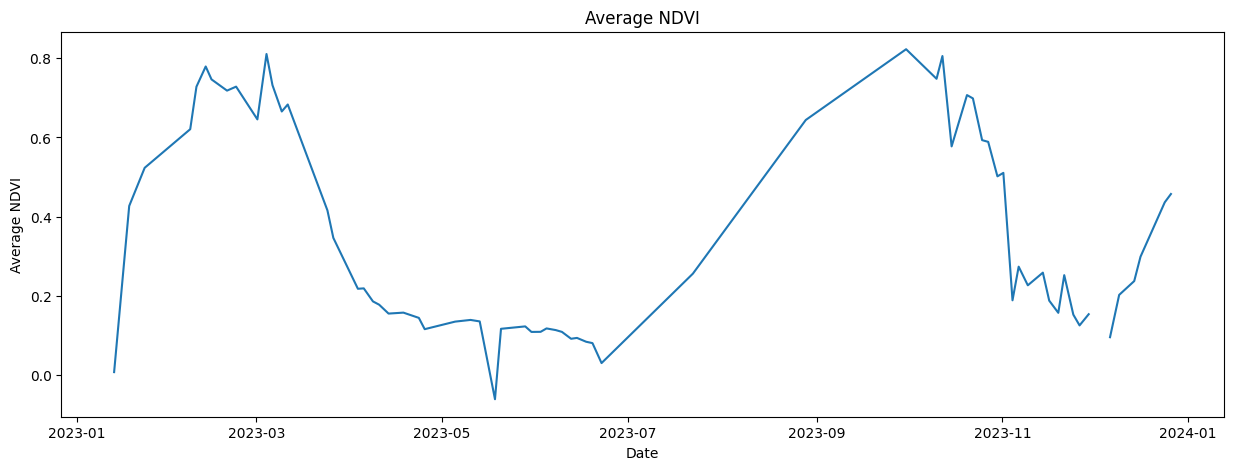

In [25]:
## Load the multi-band sentinel image dataset
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

## Filter tje data as per cloud pixel percentage, date and bounds
filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Calculate the NDVI
indices = filtered_img.map(calculate_indices).map(lambda x: summarizeRegion(x, geometry))
x,y = extract_time_series(indices)
fig = plot_time_series(x,y)

in between month of may and june, we can see a sudden dip in average values NDVI. This might be due to cloud pixels, cloud will reflect low values of NDVI. Hence to remove the clouds, we will use a technique called **cloud masking**


## Cloud masking

Masking pixels in an image makes those pixels transparent and excludes them from analysis and visualization. To mask an image, we can use the `updateMask()` function and pass it an image with 0 and 1 values. All pixels where the mask image is 0 will be masked.

Basically we are removing the cloud pixels which in this case are outliers

Most remote sensing datasets come with a QA or Cloud Mask band that contains the information on whether pixels is cloudy or not


Explore more on [Working with QA Bands and Bitmasks in google earth engine](https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/)

In [31]:
def mask2clouds(image):
    qa = image.select('QA60') ## This line selects the QA60 band from the input image, which contains quality assessment information
    cloudBitMask = 1 << 10 ## This line defines a bit mask for identifying cloud pixels. 1 << 10 means shifting the binary digit 1 by 10 positions to the left, which results in 10000000000 in binary
    cirrusBitMask = 1 << 11 ## This line defines a bit mask for identifying cirrus clouds. Similar to the cloud bit mask, this shifts the binary digit 1 by 11 positions to the left

    ## creates a mask by performing a bitwise AND operation between the QA60 band and the cloud and cirrus bit masks.
    ## Pixels where both the cloud and cirrus bit masks are equal to 0 are considered clear
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    final_image = image.updateMask(mask) #.select('B*').copyProperties(image, ['system:time_start'])

    return final_image

def maskS2clouds(image):
    '''
    Function to mask clouds using the Sentinel-2 QA band
    @param {ee.Image} image Sentinel-2 image
    @return {ee.Image} cloud masked Sentinel-2 image
    '''
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

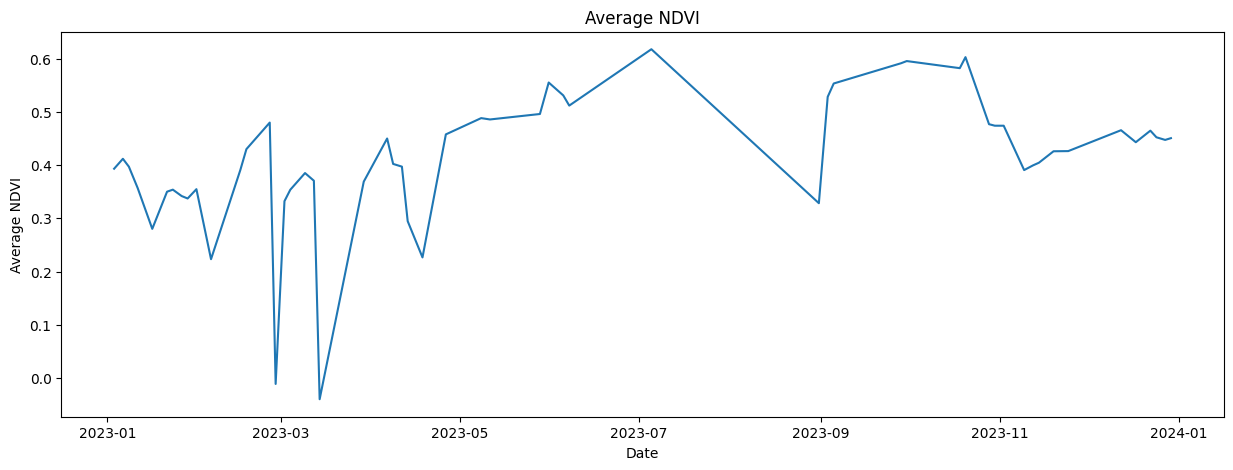

In [32]:
## Load the multi-band sentinel image dataset
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

## Filter tje data as per cloud pixel percentage, date and bounds
filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Calculate the NDVI and reduceRegion summary
indices = filtered_img.map(mask2clouds).map(calculate_indices).map(lambda x: summarizeRegion(x, geometry))
x,y = extract_time_series(indices)
fig = plot_time_series(x,y)

Exercise: PLot the timeseries NDVI plot in Tezpur Farm

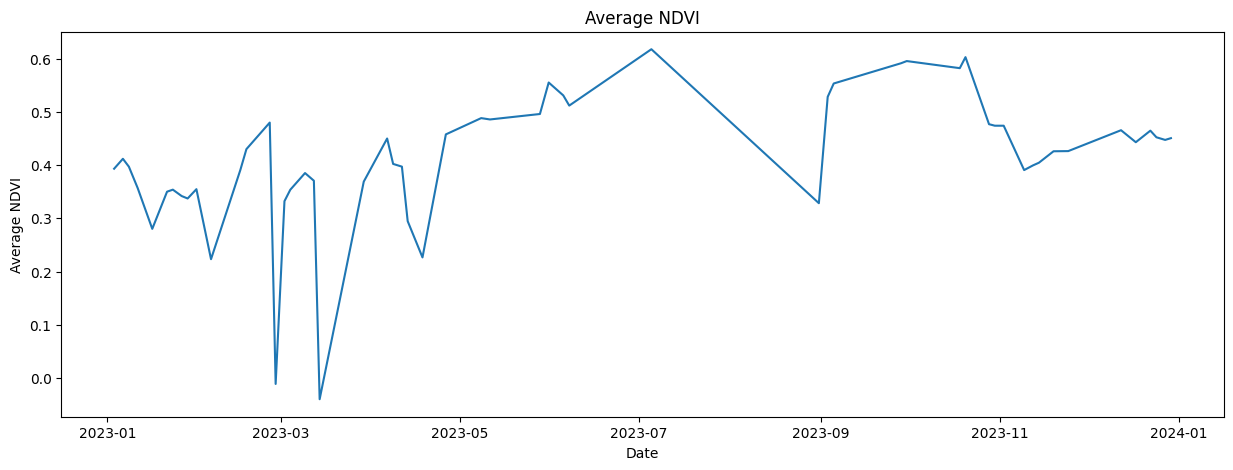

In [30]:
## Load Tezpur geometry
geometry = ee.Geometry(aoi)

## Load the multi-band sentinel image dataset
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

## Filter tje data as per cloud pixel percentage, date and bounds
filtered_img = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))\
.filter(ee.Filter.date('2023-01-01','2024-01-01'))\
.filter(ee.Filter.bounds(geometry))

## Calculate the NDVI and reduceRegion summary
indices = filtered_img.map(mask2clouds).map(calculate_indices).map(lambda x: summarizeRegion(x, geometry))
x,y = extract_time_series(indices)
fig = plot_time_series(x,y)